In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# configs / defaults

In [2]:
!pip install ml_collections

In [3]:
import jax.numpy as jnp
import ml_collections


def get_config():
    config = ml_collections.ConfigDict()

    config.use_wandb = True

    # Weights & Biases
    config.wandb = wandb = ml_collections.ConfigDict()
    wandb.project = "kdv"
    wandb.name = "current_model"
    wandb.tags = None
    wandb.group = None

    # Simulation settings
    config.data = data = ml_collections.ConfigDict()
    data.nt = 140
    data.nx = 256
    data.L = 128
    data.T = 140

    # FNO Architecture
    config.arch = arch = ml_collections.ConfigDict()
    arch.modes = 16
    arch.width = 64
    arch.seed = 0

    # Training
    config.training = training = ml_collections.ConfigDict()
    training.batch_size = 16
    training.time_history = 20
    training.time_future = 20
    training.epochs = 30 * 2 * data.nt
    training.seed = 1

    # Optimizer
    config.optim = optim = ml_collections.ConfigDict()
    optim.optimizer = "adamw"
    optim.learning_rate = 0.001
    optim.b1 = 0.9
    optim.b2 = 0.999
    optim.eps = 1e-8
    optim.eps_root = 0.0
    optim.weight_decay = 0.01
    optim.scale = 0.4
    optim.boundaries = jnp.array([10, 1200, 2400, 3600])
    return config


# models

In [4]:
from functools import partial
from typing import Callable, Dict, Tuple

import jax
import jax.numpy as jnp
import ml_collections
import optax
from flax import linen as nn
from flax.training.train_state import TrainState
from jax import jit, random, value_and_grad, vmap


def _create_optimizer(
    config: ml_collections.ConfigDict,
) -> optax.GradientTransformation:

    learning_rate = config.learning_rate

    keys_arr = config.boundaries
    vals_arr = learning_rate * config.scale ** jnp.arange(
        1, keys_arr.shape[0] + 1
    )

    def dictionary_based_schedule(step, keys_arr, vals_arr, default_lr):
        idx = jnp.sum(keys_arr <= step) - 1
        return jnp.where(idx < 0, default_lr, vals_arr[idx])

    lr = lambda step: dictionary_based_schedule(
        step, keys_arr, vals_arr, learning_rate
    )

    optimizer = optax.adamw(
        learning_rate=lr,
        b1=config.b1,
        b2=config.b2,
        eps=config.eps,
        eps_root=config.eps_root,
        weight_decay=config.weight_decay,
    )
    return optimizer


def _create_train_state(
    config: ml_collections.ConfigDict,
) -> TrainState:
    arch = config.arch
    training = config.training

    time_future = training.time_future
    time_history = training.time_history

    model = FNO1d(width=arch.width, modes=arch.modes, time_future=time_future)

    dummy_input = jnp.ones((config.data.nx, time_history))
    key = random.PRNGKey(arch.seed)
    params = model.init(key, dummy_input)

    tx = _create_optimizer(config.optim)

    state = TrainState.create(apply_fn=model.apply, params=params, tx=tx)
    return state


class FNO:
    def __init__(
        self,
        config: ml_collections.ConfigDict,
    ):
        self.config = config
        self.state = _create_train_state(config)

    def loss(
        self,
        params: Dict,
        state: TrainState,
        batch: Tuple[jnp.ndarray, jnp.ndarray],
    ) -> jnp.ndarray:
        data, labels = batch
        pred = vmap(lambda x: state.apply_fn(params, x))(data)
        loss = jnp.square(pred - labels)
        return loss.sum()

    @partial(jit, static_argnums=(0,))
    def step(
        self,
        state: TrainState,
        batch: Tuple[jnp.ndarray, jnp.ndarray],
    ) -> TrainState:
        loss, grads = value_and_grad(self.loss)(state.params, state, batch)
        state = state.apply_gradients(grads=grads)
        return state, loss


class SpectralConv1d(nn.Module):
    width: int
    modes: int

    def setup(
        self,
    ):
        scale = 1 / (self.width * self.width)
        self.weights = self.param(
            "global_kernel",
            lambda rng, shape: random.uniform(
                rng, shape, minval=0, maxval=scale
            ),
            (2, self.modes, self.width, self.width),
        )

    @nn.compact
    def __call__(
        self,
        x: jnp.ndarray,
    ) -> jnp.ndarray:
        spatial_resolution = x.shape[0]

        x_ft = jnp.fft.rfft(x, axis=0)
        x_ft_trunc = x_ft[: self.modes, :]

        R = jax.lax.complex(self.weights[0, ...], self.weights[1, ...])

        R_x_ft = jnp.einsum("Mio,Mi->Mo", R, x_ft_trunc)

        result = jnp.zeros((x_ft.shape[0], self.width), dtype=x_ft.dtype)
        result = result.at[: self.modes, :].set(R_x_ft)

        inv_ft_R_x_ft = jnp.fft.irfft(result, n=spatial_resolution, axis=0)
        return inv_ft_R_x_ft


class FNOBlock1d(nn.Module):
    width: int
    modes: int
    activation: Callable

    @nn.compact
    def __call__(
        self,
        x: jnp.ndarray,
    ) -> jnp.ndarray:
        spectral_conv = SpectralConv1d(self.width, self.modes)(x)
        local_conv = nn.Conv(self.width, kernel_size=(1,), name="local")(x)
        return self.activation(spectral_conv + local_conv)


class FNO1d(nn.Module):
    width: int
    modes: int
    time_future: int

    @nn.compact
    def __call__(
        self,
        x: jnp.ndarray,
    ) -> jnp.ndarray:
        x = nn.Dense(self.width)(x)

        x = FNOBlock1d(self.width, self.modes, nn.gelu)(x)
        x = FNOBlock1d(self.width, self.modes, nn.gelu)(x)
        x = FNOBlock1d(self.width, self.modes, nn.gelu)(x)
        x = FNOBlock1d(self.width, self.modes, nn.gelu)(x)

        x = nn.Dense(128)(x)
        x = nn.gelu(x)
        x = nn.Dense(self.time_future)(x)
        return x


# utils

In [5]:
from typing import Tuple

import jax.numpy as jnp
import torch
import h5py
from torch.utils.data import DataLoader, Dataset


def to_coords(
    x: torch.Tensor,
    t: torch.Tensor,
) -> torch.Tensor:
    x_, t_ = torch.meshgrid(x, t)
    x_ = x_.T
    t_ = t_.T
    return torch.stack((x_, t_), -1)


class HDF5Dataset(Dataset):
    def __init__(
        self,
        path: str,
        mode: str,
        nt: int,
        nx: int,
        dtype=torch.float64,
        load_all: bool = False,
    ):
        super().__init__()
        f = h5py.File(path, "r")
        self.mode = mode
        self.dtype = dtype
        self.data = f[self.mode]
        self.dataset = f"pde_{nt}-{nx}"

        if load_all:
            data = {self.dataset: self.data[self.dataset][:]}
            f.close()
            self.data = data

    def __len__(
        self,
    ) -> int:
        return self.data[self.dataset].shape[0]

    def __getitem__(
        self,
        idx: int,
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        u = self.data[self.dataset][idx]
        x = self.data["x"][idx]
        t = self.data["t"][idx]
        dx = self.data["dx"][idx]
        dt = self.data["dt"][idx]

        if self.mode == "train":
            X = to_coords(torch.tensor(x), torch.tensor(t))
            sol = (torch.tensor(u), X)
            u = sol[0]
            X = sol[1]
            dx = X[0, 1, 0] - X[0, 0, 0]
            dt = X[1, 0, 1] - X[0, 0, 1]
        else:
            u = torch.from_numpy(u)
            dx = torch.tensor([dx])
            dt = torch.tensor([dt])
        return u.float(), dx.float(), dt.float()


def create_dataloader(
    data_string: str,
    mode: str,
    nt: int,
    nx: int,
    batch_size: int,
) -> DataLoader:
    try:
        dataset = HDF5Dataset(data_string, mode, nt=nt, nx=nx)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    except:
        raise Exception("Datasets could not be loaded properly")
    return loader


def create_data(
    datapoints: torch.Tensor,
    start_time: list,
    time_future: int,
    time_history: int,
) -> Tuple[torch.Tensor, torch.Tensor]:
    data = torch.Tensor()
    labels = torch.Tensor()

    for dp, start in zip(datapoints, start_time):
        end_time = start + time_history
        d = dp[start:end_time]
        target_start_time = end_time
        target_end_time = target_start_time + time_future
        l = dp[target_start_time:target_end_time]

        data = torch.cat((data, d[None, :]), 0)
        labels = torch.cat((labels, l[None, :]), 0)
    return jnp.array(data), jnp.array(labels)


# results

True
True
True
True
True


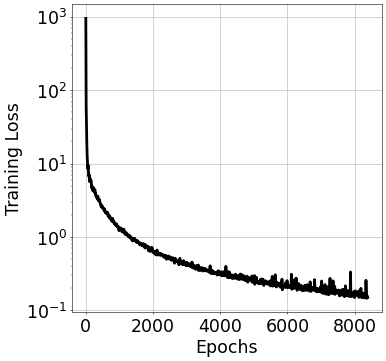

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb:   1 of 1 files downloaded.  


0.079641685
81.640625


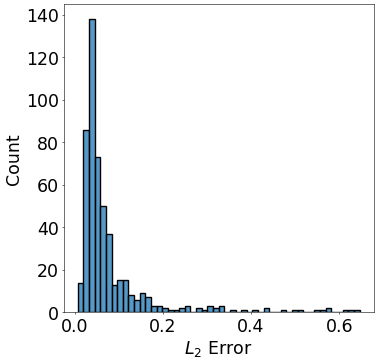

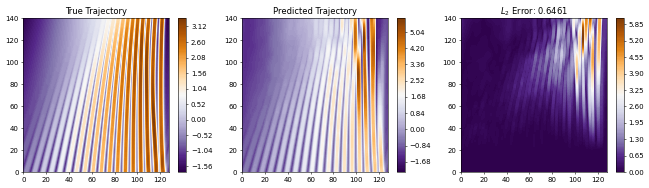

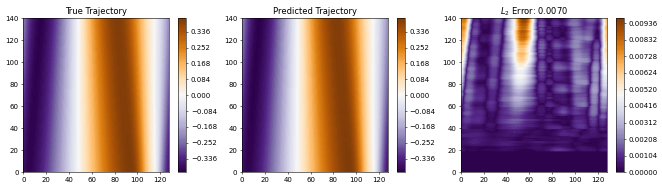

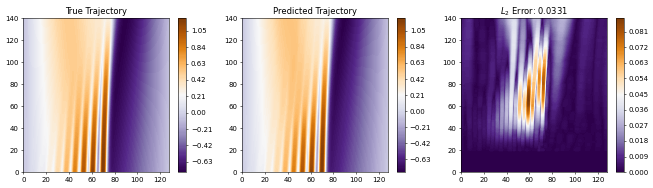

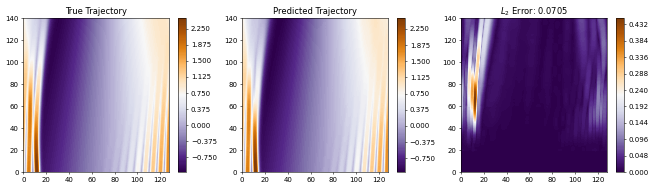

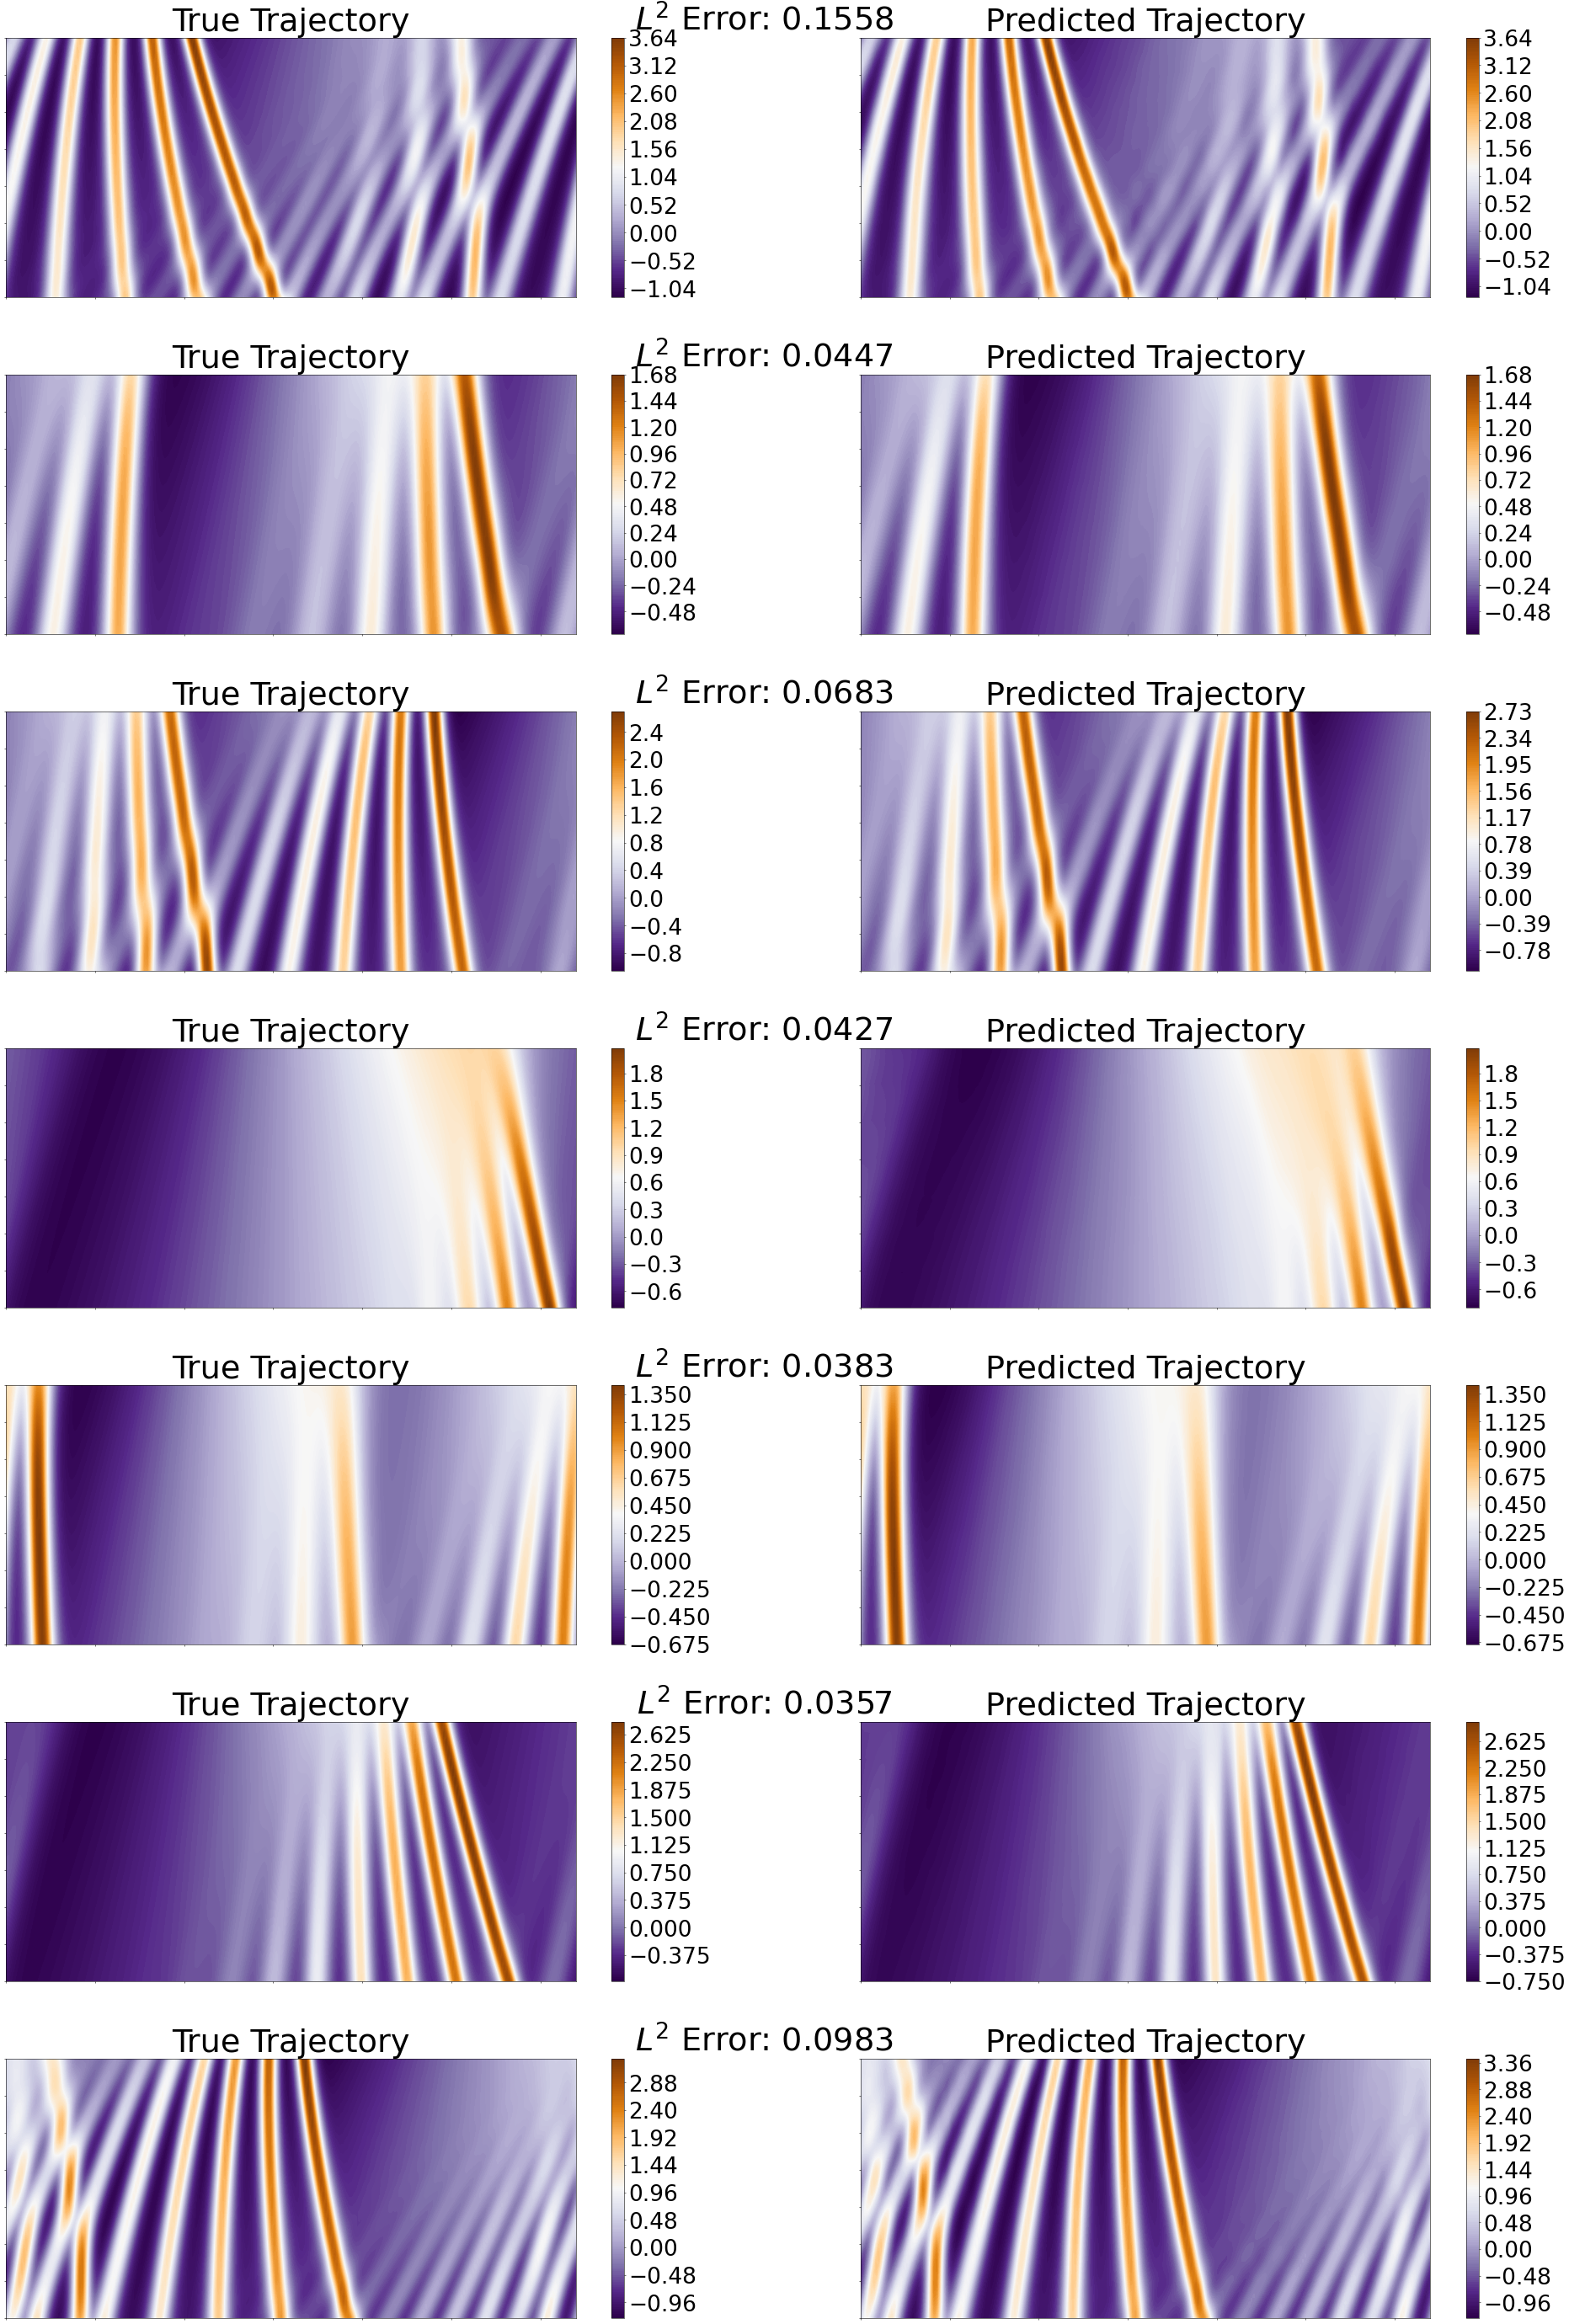

In [6]:
import pickle
import os

import matplotlib.pyplot as plt
import jax.numpy as jnp
import seaborn as sns
import numpy as npy
import wandb
from jax import random

wandb_username = "skoohy-penn"

api = wandb.Api()
runs = list(api.runs("kdv"))
run = runs[-1]
run_name = run.name
config = run.config

loss = []
for record in run.scan_history(keys=["train_loss"]):
    if "train_loss" in record:
        loss.append(record["train_loss"])

# dpi = 200
dpi = 50

fig, ax = plt.subplots(figsize=(8, 8), dpi=dpi)
ax.plot(range(0, 8400, 10), loss, c="k", lw=4)
ax.tick_params(axis="both", labelsize=25)
ax.set_yscale("log")
ax.set_ylabel("Training Loss", fontsize=25)
ax.set_xlabel("Epochs", fontsize=25)
ax.grid()
plt.show()

artifact = api.artifact(
    f"{wandb_username}/kdv/{run.name}_model_params:latest",
    type="model",
)

artifact_dir = artifact.download()

file_path = os.path.join(artifact_dir, f"{run_name}_model_params.pkl")

with open(file_path, "rb") as f:
    loaded_params = pickle.load(f)

full_config = get_config()
model = FNO(full_config)
model.state = model.state.replace(params=loaded_params)

with h5py.File("/content/drive/My Drive/data/KdV_test.h5", "r") as f:
    data = f["test"]["pde_140-256"][:]

test_data = jnp.array(data)

start = 0
end_time = 20

time_history = 20
time_future = 20

true_trajectory = test_data
pred_trajectory = npy.zeros(test_data.shape)

for i in range(test_data.shape[0]):
    start = 0
    end_time = 20

    time_history = 20
    time_future = 20

    data = true_trajectory[i, start:end_time, :]
    pred_trajectory[i, start:end_time, :] = data

    start += end_time
    end_time += time_future

    data = jnp.permute_dims(data, (1, 0))

    while end_time <= 140:
        pred = model.state.apply_fn(model.state.params, data)
        data = pred

        pred_trajectory[i, start:end_time, :] = jnp.permute_dims(data, (1, 0))

        start = end_time
        end_time += time_future

nx = full_config.data.nx
nt = full_config.data.nt
num_test = true_trajectory.shape[0]

true_reshape = true_trajectory.reshape(num_test, nx * nt)
pred_reshape = pred_trajectory.reshape(num_test, nx * nt)

l2_errors = jnp.linalg.norm(
    true_reshape - pred_reshape, axis=1
) / jnp.linalg.norm(true_reshape, axis=1)

print(l2_errors.mean())
print(((l2_errors < 0.1).sum() / l2_errors.shape[0]) * 100)

# model was retrained from the notebook plots may be different than in the paper

fig, ax = plt.subplots(figsize=(8, 8), dpi=dpi)
sns.histplot(l2_errors, legend=False, linewidth=2, bins=50)
ax.tick_params(axis="both", labelsize=25)
ax.set_ylabel("Count", fontsize=25)
ax.set_xlabel("$L_2$ Error", fontsize=25)
plt.show()

idx_worst = jnp.argmax(l2_errors)
idx_best = jnp.argmin(l2_errors)

idx_all = range(l2_errors.shape[0])
choices = jnp.array(
    [idx for idx in idx_all if idx not in (idx_worst, idx_best)]
)

test_idx = random.choice(random.PRNGKey(45678), choices, shape=(2,))

idx_list = jnp.concatenate((jnp.array([idx_worst, idx_best]), test_idx))

domain = full_config.data

x = jnp.linspace(0, domain.L, domain.nx)
t = jnp.linspace(0, domain.T, domain.nt)
XX, TT = jnp.meshgrid(x, t)

for idx in idx_list:
    fig, ax = plt.subplots(1, 3, figsize=(16, 4), dpi=dpi)
    contour = ax[0].contourf(
        XX, TT, true_trajectory[idx, ...], 150, cmap="PuOr_r"
    )
    fig.colorbar(contour, ax=ax[0])
    ax[0].set_title("True Trajectory")

    contour.set_edgecolor("face")

    contour = ax[1].contourf(
        XX, TT, pred_trajectory[idx, ...], 150, cmap="PuOr_r"
    )
    fig.colorbar(contour, ax=ax[1])
    ax[1].set_title("Predicted Trajectory")

    contour.set_edgecolor("face")

    contour = ax[2].contourf(
        XX,
        TT,
        abs(true_trajectory[idx, ...] - pred_trajectory[idx, ...]),
        150,
        cmap="PuOr_r",
    )
    fig.colorbar(contour, ax=ax[2])
    ax[2].set_title("$L_2$ Error:" + " {:.4f}".format(l2_errors[idx]))

    contour.set_edgecolor("face")

    plt.show()

num_ex = 7

choices = jnp.array([idx for idx in idx_all if idx not in idx_list])
rand_ex = random.choice(
    random.PRNGKey(9876), choices, shape=(num_ex,), replace=False
)

fig = plt.figure(figsize=(6 * 8, 7 * 8), constrained_layout=False, dpi=dpi)
fig.subplots_adjust(hspace=0.05)

subfigs = fig.subfigures(nrows=num_ex, ncols=1)

for row, subfig in enumerate(subfigs):
    idx = rand_ex[row]
    subfig.suptitle(f"$L^2$ Error: {l2_errors[idx]:.4f}", fontsize=55)

    axs = subfig.subplots(nrows=1, ncols=2)
    for i, ax in enumerate(axs):
        if i == 0:
            contour = ax.contourf(
                XX, TT, true_trajectory[idx, ...], 150, cmap="PuOr_r"
            )
            ax.set_title("True Trajectory", fontsize=55)
            contour.set_edgecolor("face")
        else:
            contour = ax.contourf(
                XX, TT, pred_trajectory[idx, ...], 150, cmap="PuOr_r"
            )
            ax.set_title("Predicted Trajectory", fontsize=55)
            contour.set_edgecolor("face")

        cbar = fig.colorbar(contour, ax=ax)
        cbar.ax.tick_params(labelsize=38)

        ax.set_xticklabels([])
        ax.set_yticklabels([])
plt.show()
